### Setting the environment

In [3]:
!pip install fastNLP==1.0.1 -q
!pip install transformers -q
!pip install sparse==0.13.0 -q
!pip install torch==1.11.0+cu113 --extra-index-url https://download.pytorch.org/whl/cu113 -q
!pip install llvmlite==0.38.1 --user -q
!pip install numba==0.55.2 --user -q
!pip install adjustText -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.7/644.7 kB 43.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.3/217.3 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 758.2 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.11.0+cu113 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, b

In [4]:
import torch
print(torch.__version__)

1.11.0+cu113


In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [6]:
!pip install torch-scatter==2.0.9 --no-index -f https://data.pyg.org/whl/torch-{torch.__version__}.html 

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 4.8 MB/s eta 0:00:00


In [7]:
import json
import warnings
import argparse

if 'p' in os.environ:
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['p']
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['MKL_THREADING_LAYER'] = 'GNU'
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import fastNLP
from fastNLP import cache_results, prepare_torch_dataloader
from fastNLP import Evaluator
from fastNLP import SortedSampler, BucketedBatchSampler

from model.model import CNNNer
from model.metrics import NERMetric
from preprocessing.ner_pipe import SpanNerPipe
from preprocessing.padder import Torch3DMatrixPadder
from model.metrics_utils import decode
from fastNLP import print as pr
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
from adjustText import adjust_text 


seed_value=42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
os.environ['FASTNLP_GLOBAL_SEED'] = str(seed_value)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def calculate(path):
    max_sent_len = 0
    total_lengths = 0
    total_ent_length = 0
    max_ent_length = 0
    num_ents = 0
    overlapped_ent_num = 0
    num_sent = 0
    with open(path, 'r') as f:
        for line in f:
            num_sent += 1
            data = json.loads(line.strip())
            max_sent_len = max(max_sent_len, len(data['tokens']))
            total_lengths += len(data['tokens'])
            flags = [0]*len(data['tokens'])
            for ent in data['entity_mentions']:
                num_ents += 1
                start, end = ent['start'], ent['end']
                total_ent_length += ent['end'] - ent['start']
                max_ent_length = max(max_ent_length, ent['end'] - ent['start'])
                for i in range(start, end):
                    flags[i] += 1
            for ent in data['entity_mentions']:
                start, end = ent['start'], ent['end']
                if any([flags[i]>1 for i in range(start, end)]):
                    overlapped_ent_num += 1

    pr(f"For {path}")
    pr("total sentence ", num_sent)
    pr("average sentence length ", total_lengths/num_sent)
    pr("max sentence length ", max_sent_len)

    pr('num_entities ', num_ents)
    pr('average entity length  ', total_ent_length/num_ents)
    pr('max entity length  ', max_ent_length)
    pr("Number of nested entity ", overlapped_ent_num)

    pr("Number of tokens ", total_lengths)
    pr()
    
def get_stats(directory): 
    for name in ['train', 'dev', 'test']:
        path = f'{directory}/{name}.jsonl'
        calculate(path)

In [9]:
get_stats('datasets/outputs/nerel_common_labels')

[21:42:14] INFO     For datasets/outputs/nerel_common_label ]8;id=114369;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=304191;file://<ipython-input-8-34328a1283e6>#28\28]8;;\
                    s/train.jsonl                                                            

           INFO     total sentence  3983                    ]8;id=572436;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=792352;file://<ipython-input-8-34328a1283e6>#29\29]8;;\

           INFO     average sentence length                 ]8;id=570044;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=746561;file://<ipython-input-8-34328a1283e6>#30\30]8;;\
                    40.530253577705246                                                       

           INFO     max sentence length  408                ]8;id=158005;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=664683;file://<ipython-input-8-34328a1283e6>#31\31]8;;\

           INFO     num_entities  29651                     ]8;id=458847;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=339201;file://<ipython-input-8-34328a1283e6>#33\33]8;;\

           INFO     average entity length                   ]8;id=941064;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=626092;file://<ipython-input-8-34328a1283e6>#34\34]8;;\
                    1.863849448585208                                                        

           INFO     max entity length   17                  ]8;id=69358;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=723071;file://<ipython-input-8-34328a1283e6>#35\35]8;;\

           INFO     Number of nested entity  8691           ]8;id=585976;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=961634;file://<ipython-input-8-34328a1283e6>#36\36]8;;\

           INFO     Number of tokens  161432                ]8;id=144867;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=28506;file://<ipython-input-8-34328a1283e6>#38\38]8;;\

           INFO                                             ]8;id=33255;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=429692;file://<ipython-input-8-34328a1283e6>#39\39]8;;\

[21:42:15] INFO     For datasets/outputs/nerel_common_label ]8;id=880420;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=74285;file://<ipython-input-8-34328a1283e6>#28\28]8;;\
                    s/dev.jsonl                                                              

           INFO     total sentence  475                     ]8;id=555661;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=258025;file://<ipython-input-8-34328a1283e6>#29\29]8;;\

           INFO     average sentence length                 ]8;id=243955;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=375156;file://<ipython-input-8-34328a1283e6>#30\30]8;;\
                    40.30947368421052                                                        

           INFO     max sentence length  438                ]8;id=187087;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=838533;file://<ipython-input-8-34328a1283e6>#31\31]8;;\

           INFO     num_entities  3467                      ]8;id=987835;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=50546;file://<ipython-input-8-34328a1283e6>#33\33]8;;\

           INFO     average entity length                   ]8;id=676530;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=815827;file://<ipython-input-8-34328a1283e6>#34\34]8;;\
                    1.8148254975483127                                                       

           INFO     max entity length   11                  ]8;id=338683;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=250247;file://<ipython-input-8-34328a1283e6>#35\35]8;;\

           INFO     Number of nested entity  848            ]8;id=756336;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=585177;file://<ipython-input-8-34328a1283e6>#36\36]8;;\

           INFO     Number of tokens  19147                 ]8;id=663448;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=206;file://<ipython-input-8-34328a1283e6>#38\38]8;;\

           INFO                                             ]8;id=395253;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=509714;file://<ipython-input-8-34328a1283e6>#39\39]8;;\

[21:42:16] INFO     For datasets/outputs/nerel_common_label ]8;id=153940;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=970103;file://<ipython-input-8-34328a1283e6>#28\28]8;;\
                    s/test.jsonl                                                             

           INFO     total sentence  471                     ]8;id=948044;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=458684;file://<ipython-input-8-34328a1283e6>#29\29]8;;\

           INFO     average sentence length                 ]8;id=320542;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=825201;file://<ipython-input-8-34328a1283e6>#30\30]8;;\
                    41.40127388535032                                                        

           INFO     max sentence length  192                ]8;id=918270;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=248289;file://<ipython-input-8-34328a1283e6>#31\31]8;;\

           INFO     num_entities  3513                      ]8;id=895534;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=452568;file://<ipython-input-8-34328a1283e6>#33\33]8;;\

           INFO     average entity length                   ]8;id=960630;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=468323;file://<ipython-input-8-34328a1283e6>#34\34]8;;\
                    1.8855678906917164                                                       

           INFO     max entity length   16                  ]8;id=266144;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=384284;file://<ipython-input-8-34328a1283e6>#35\35]8;;\

           INFO     Number of nested entity  999            ]8;id=195286;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=702865;file://<ipython-input-8-34328a1283e6>#36\36]8;;\

           INFO     Number of tokens  19500                 ]8;id=721062;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=428348;file://<ipython-input-8-34328a1283e6>#38\38]8;;\

           INFO                                             ]8;id=321423;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=915029;file://<ipython-input-8-34328a1283e6>#39\39]8;;\

In [10]:
get_stats('datasets/outputs/nerel_bio_common_labels')

[21:42:17] INFO     For datasets/outputs/nerel_bio_common_l ]8;id=39920;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=688252;file://<ipython-input-8-34328a1283e6>#28\28]8;;\
                    abels/train.jsonl                                                        

           INFO     total sentence  4767                    ]8;id=714207;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=293136;file://<ipython-input-8-34328a1283e6>#29\29]8;;\

           INFO     average sentence length                 ]8;id=859856;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=536001;file://<ipython-input-8-34328a1283e6>#30\30]8;;\
                    27.719320327249843                                                       

           INFO     max sentence length  182                ]8;id=83677;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=66470;file://<ipython-input-8-34328a1283e6>#31\31]8;;\

           INFO     num_entities  23791                     ]8;id=568085;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=99313;file://<ipython-input-8-34328a1283e6>#33\33]8;;\

           INFO     average entity length                   ]8;id=373127;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=96002;file://<ipython-input-8-34328a1283e6>#34\34]8;;\
                    1.64209154722374                                                         

           INFO     max entity length   14                  ]8;id=959845;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=508189;file://<ipython-input-8-34328a1283e6>#35\35]8;;\

           INFO     Number of nested entity  8011           ]8;id=581567;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=271884;file://<ipython-input-8-34328a1283e6>#36\36]8;;\

           INFO     Number of tokens  132138                ]8;id=255301;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=732985;file://<ipython-input-8-34328a1283e6>#38\38]8;;\

           INFO                                             ]8;id=574468;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=305662;file://<ipython-input-8-34328a1283e6>#39\39]8;;\

[21:42:18] INFO     For datasets/outputs/nerel_bio_common_l ]8;id=42965;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=963046;file://<ipython-input-8-34328a1283e6>#28\28]8;;\
                    abels/dev.jsonl                                                          

           INFO     total sentence  663                     ]8;id=799518;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=596169;file://<ipython-input-8-34328a1283e6>#29\29]8;;\

           INFO     average sentence length                 ]8;id=457274;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=82567;file://<ipython-input-8-34328a1283e6>#30\30]8;;\
                    28.800904977375566                                                       

           INFO     max sentence length  144                ]8;id=279182;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=115276;file://<ipython-input-8-34328a1283e6>#31\31]8;;\

           INFO     num_entities  3029                      ]8;id=213360;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=552108;file://<ipython-input-8-34328a1283e6>#33\33]8;;\

           INFO     average entity length                   ]8;id=487774;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=694485;file://<ipython-input-8-34328a1283e6>#34\34]8;;\
                    1.6196764608781775                                                       

           INFO     max entity length   14                  ]8;id=382764;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=528181;file://<ipython-input-8-34328a1283e6>#35\35]8;;\

           INFO     Number of nested entity  815            ]8;id=4581;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=555042;file://<ipython-input-8-34328a1283e6>#36\36]8;;\

           INFO     Number of tokens  19095                 ]8;id=571656;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=435669;file://<ipython-input-8-34328a1283e6>#38\38]8;;\

           INFO                                             ]8;id=17291;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=445319;file://<ipython-input-8-34328a1283e6>#39\39]8;;\

           INFO     For datasets/outputs/nerel_bio_common_l ]8;id=457929;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=169590;file://<ipython-input-8-34328a1283e6>#28\28]8;;\
                    abels/test.jsonl                                                         

           INFO     total sentence  662                     ]8;id=384303;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=765160;file://<ipython-input-8-34328a1283e6>#29\29]8;;\

           INFO     average sentence length                 ]8;id=544070;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=325602;file://<ipython-input-8-34328a1283e6>#30\30]8;;\
                    29.11631419939577                                                        

           INFO     max sentence length  115                ]8;id=137860;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=271972;file://<ipython-input-8-34328a1283e6>#31\31]8;;\

           INFO     num_entities  3128                      ]8;id=724274;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=622357;file://<ipython-input-8-34328a1283e6>#33\33]8;;\

           INFO     average entity length                   ]8;id=186656;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=220109;file://<ipython-input-8-34328a1283e6>#34\34]8;;\
                    1.667838874680307                                                        

           INFO     max entity length   10                  ]8;id=830050;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=987071;file://<ipython-input-8-34328a1283e6>#35\35]8;;\

           INFO     Number of nested entity  880            ]8;id=112743;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=774150;file://<ipython-input-8-34328a1283e6>#36\36]8;;\

           INFO     Number of tokens  19275                 ]8;id=52543;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=562392;file://<ipython-input-8-34328a1283e6>#38\38]8;;\

           INFO                                             ]8;id=741455;file://<ipython-input-8-34328a1283e6>\<ipython-input-8-34328a1283e6>]8;;\:]8;id=340635;file://<ipython-input-8-34328a1283e6>#39\39]8;;\

### Fetching and preprocessing the dataset

In [11]:
model_name = 'DeepPavlov/rubert-base-cased'


# @cache_results('caches/ner_caches.pkl', _refresh=False)
def get_data(dataset_name, model_name):
    paths = f'datasets/outputs/{dataset_name}'
    pipe = SpanNerPipe(model_name=model_name)
    dl = pipe.process_from_file(paths)
    return dl, pipe.matrix_segs

def densify(x):
    x = x.todense().astype(np.float32)
    return x
    
def preprocess_data(dataset_name, model_name):

    dl, matrix_segs = get_data(dataset_name, model_name)

    dl.apply_field(densify, field_name='matrix', new_field_name='matrix', progress_bar='Densify')

    print(dl)

    label2idx = getattr(dl, 'ner_vocab') if hasattr(dl, 'ner_vocab') else getattr(dl, 'label2idx')
    print(f"{len(label2idx)} labels: {label2idx}, matrix_segs:{matrix_segs}")

    dls = {}
    for name, ds in dl.iter_datasets():
        ds.set_pad('matrix', pad_fn=Torch3DMatrixPadder(pad_val=ds.collator.input_fields['matrix']['pad_val'],
                                                        num_class=matrix_segs['ent'],
                                                        batch_size=1))

        _dl = prepare_torch_dataloader(ds, batch_size=1, num_workers=0, pin_memory=True, shuffle=False)

        dls[name] = _dl
    
    return dls, label2idx, matrix_segs

In [12]:
dls_nerel, label2idx_nerel, matrix_segs_nerel = preprocess_data('nerel_common_labels', model_name)

In total 3 datasets:
	dev has 476 instances.
	test has 471 instances.
	train has 3984 instances.

16 labels: {'AGE': 0, 'CITY': 1, 'COUNTRY': 2, 'DATE': 3, 'DISEASE': 4, 'FACILITY': 5, 'LOCATION': 6, 'NUMBER': 7, 'ORDINAL': 8, 'ORGANIZATION': 9, 'PERCENT': 10, 'PERSON': 11, 'PRODUCT': 12, 'PROFESSION': 13, 'STATE_OR_PROVINCE': 14, 'TIME': 15}, matrix_segs:{'ent': 16}


In [13]:
dls_nerel_bio, label2idx_nerel_bio, matrix_segs_nerel_bio = preprocess_data('nerel_bio_common_labels', model_name)

In total 3 datasets:
	dev has 663 instances.
	test has 662 instances.
	train has 4767 instances.

16 labels: {'AGE': 0, 'CITY': 1, 'COUNTRY': 2, 'DATE': 3, 'DISEASE': 4, 'FACILITY': 5, 'LOCATION': 6, 'NUMBER': 7, 'ORDINAL': 8, 'ORGANIZATION': 9, 'PERCENT': 10, 'PERSON': 11, 'PRODUCT': 12, 'PROFESSION': 13, 'STATE_OR_PROVINCE': 14, 'TIME': 15}, matrix_segs:{'ent': 16}


### Experiments on data

In [14]:
def squeeze_batch_dim(input_list):
    for i in range(len(input_list)):
        input_list[i] = input_list[i][0]
    return input_list

def get_key_by_value(dictionary, value):
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

def get_targets(dataloader):
    tokens_list = []
    targets_list = []
    for i, item in enumerate(dataloader):
        tokens = item['tokens']
        target = item['ent_target']
        tokens_list.append(tokens)
        targets_list.append(target)
    return tokens_list, targets_list


def split_by_label(targets, label2idx):
    tpl = {key:set() for key in range(len(label2idx))}

    for i in range(len(targets)):
        cur_target = set(map(tuple, targets[i]))
        for item in cur_target:
            tpl[item[2]].add(item)
    return tpl


def decode_targets(tokens_list, targets_list):
    tokens_with_label = [None]*len(targets_list)
    for i in range(len(targets_list)):
        target_tokens = []
        for span in targets_list[i]:
            start, end, label = span
            target_tokens.append([tokens_list[i][start:end+1], label])
        tokens_with_label[i] = target_tokens
    return tokens_with_label


def split_tokens_with_label_by_category(tokens_with_label, label2idx, tpl=None):
    if tpl is None:
        tpl = {key:set() for key in range(len(label2idx))}
        
    for i in range(len(tokens_with_label)):
        cur_tokens_with_label = tokens_with_label[i]
        for j in range(len(cur_tokens_with_label)):
            tpl[cur_tokens_with_label[j][1]].update(cur_tokens_with_label[j][0])
    return tpl


def build_vocab(dataloader, label2idx):
    tokens_with_label_dict = {key:set() for key in range(len(label2idx))}

    for name in ['train', 'test', 'dev']:
        tokens_list, targets_list = get_targets(dataloader[name])
        tokens_list = squeeze_batch_dim(tokens_list)
        targets_list = squeeze_batch_dim(targets_list)
        tokens_with_label = decode_targets(tokens_list, targets_list)
        tokens_with_label_dict = split_tokens_with_label_by_category(tokens_with_label, label2idx_nerel, tpl=tokens_with_label_dict)
        
    return tokens_with_label_dict

In [15]:
vocab_nerel = build_vocab(dls_nerel, label2idx_nerel)
vocab_nerel_bio = build_vocab(dls_nerel_bio, label2idx_nerel_bio)

In [16]:
overlap = {key:0 for key in range(len(label2idx_nerel))}
identical_tokens = {key:[] for key in range(len(label2idx_nerel))}

for i in range(len(label2idx_nerel)):
    intersection = vocab_nerel[i] & vocab_nerel_bio[i]
    overlap[i] = round(len(intersection) / (len(vocab_nerel[i] | vocab_nerel_bio[i]) + 1e-6) * 100, 2)
    identical_tokens[i] = list(intersection)

    
overlap_str = {}
identical_tokens_str = {}

for i in range(len(overlap)):
    overlap_str[get_key_by_value(label2idx_nerel, i)] = overlap[i]
    identical_tokens_str[get_key_by_value(label2idx_nerel, i)] = identical_tokens[i]

In [17]:
sim_data = {'Overlap': list(overlap_str.values())}

df_overlap = pd.DataFrame(data=sim_data, index=list(overlap_str.keys()))

df_overlap.index.name = 'Index'

df_overlap.transpose()

Index,AGE,CITY,COUNTRY,DATE,DISEASE,FACILITY,LOCATION,NUMBER,ORDINAL,ORGANIZATION,PERCENT,PERSON,PRODUCT,PROFESSION,STATE_OR_PROVINCE,TIME
Overlap,8.94,1.36,7.27,7.99,2.02,2.02,7.72,9.73,11.18,3.05,3.22,2.04,2.15,1.14,4.75,7.54


In [18]:
overlap_str

{'AGE': 8.94,
 'CITY': 1.36,
 'COUNTRY': 7.27,
 'DATE': 7.99,
 'DISEASE': 2.02,
 'FACILITY': 2.02,
 'LOCATION': 7.72,
 'NUMBER': 9.73,
 'ORDINAL': 11.18,
 'ORGANIZATION': 3.05,
 'PERCENT': 3.22,
 'PERSON': 2.04,
 'PRODUCT': 2.15,
 'PROFESSION': 1.14,
 'STATE_OR_PROVINCE': 4.75,
 'TIME': 7.54}

In [19]:
overlap_sorted = dict(sorted(overlap_str.items(), key=lambda item: item[1]))
sorted_keys = list(overlap_sorted.keys())

In [20]:
sorted_keys = ['PROF', 'CITY', 'DIS', 'FAC', 'PERS', 'PROD', 'ORG', 'PERC', 'S_O_P', 'CTRY', 'TIME', 'LOC', 'DATE', 'AGE', 'NUM', 'ORD']

In [21]:
f1_score_nerel_bio = {'AGE': 83.67,
 'CITY': 66.67,
 'CTRY': 79.39,
 'DATE': 78.97,
 'DIS': 87.96,
 'FAC': 0.0,
 'LOC': 78.26,
 'NUM': 83.14,
 'ORD': 87.5,
 'ORG': 66.67,
 'PERC': 81.82,
 'PERS': 26.03,
 'PROD': 11.11,
 'PROF': 90.2,
 'S_O_P': 87.5,
 'TIME': 66.67}

f1_scores = [f1_score_nerel_bio[key] for key in sorted_keys]

print(f1_scores)

[90.2, 66.67, 87.96, 0.0, 26.03, 11.11, 66.67, 81.82, 87.5, 79.39, 66.67, 78.26, 78.97, 83.67, 83.14, 87.5]


In [22]:
corr = np.corrcoef(list(overlap_sorted.values()), f1_scores)
corr

array([[1.        , 0.45220428],
       [0.45220428, 1.        ]])

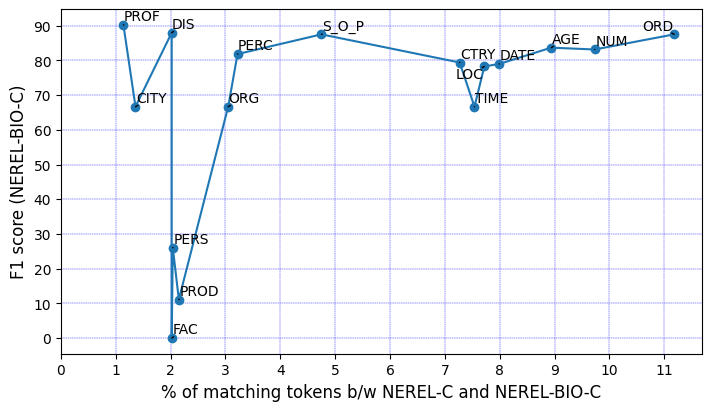

In [23]:
x = list(overlap_sorted.values())
y = f1_scores

# plt.figure(figsize=(8,4))

fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(4)
fig.set_figwidth(7)

ax.grid(color = 'blue', linestyle = '--', linewidth = 0.3)


ax.plot(x, y, marker='o', linewidth=1.5) 
# for i, key in enumerate(sorted_keys):
#     ax.annotate(key, (x[i], y[i]), xycoords='data')

texts = [ax.text(x[i], y[i], sorted_keys[i]) for i in range(len(x))]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))

ax.set_xticks(np.arange(0, 12, 1))
ax.set_yticks(np.arange(0, 100, 10))

ax.set_xlabel('% of matching tokens b/w NEREL-C and NEREL-BIO-C', fontsize=12) 
ax.set_ylabel('F1 score (NEREL-BIO-C)', fontsize=12) 
# ax.legend(fontsize=12)

plt.show() 

In [24]:
nerel_bio_f1 =   [89.80, 66.67, 92.21, 78.43, 93.09, 42.55, 21.05, 89.12, 79.41, 82.05, 92.50, 90.98, 40.00, 76.00, 70.00, 71.43]
nerel_bio_c_f1 = [83.67, 66.67, 79.39, 78.97, 87.96, 0.00, 78.26, 83.14, 87.50, 66.67, 81.82, 26.03, 11.11, 90.20, 87.50, 66.67]

subtracted = [element1 - element2 for (element1, element2) in zip(nerel_bio_c_f1, nerel_bio_f1)]

print(sum(subtracted)/len(subtracted))

-6.233125
